<a href="https://colab.research.google.com/github/boqchen/Mathematical-Foundations-of-Computer-Graphics-and-Vision---SS21/blob/main/MCGV_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [290]:
import numpy as np
import cv2
import scipy
import scipy.io
from scipy.optimize import linprog
from math import floor, ceil

In [291]:
def SplitProblem(parent):

  Tx_ub = parent.ThetaUpperBound[0];
  Ty_ub = parent.ThetaUpperBound[1];
  Tx_lb = parent.ThetaLowerBound[0];
  Ty_lb = parent.ThetaLowerBound[1];
    
  x_range = Tx_ub - Tx_lb;
  y_range = Ty_ub - Ty_lb;
    
  if x_range > y_range:

    mid = Tx_lb + x_range/2;
        
    left_child = NewProblem([Tx_lb, Ty_lb], [floor(mid), Ty_ub])
    right_child = NewProblem([ceil(mid), Ty_lb], [Tx_ub, Ty_ub])
  
  else:
    mid = Ty_lb + y_range/2;
        
    left_child = NewProblem([Tx_lb, Ty_lb], [Tx_ub, floor(mid)])
    right_child = NewProblem([Tx_lb, ceil(mid)], [Tx_ub, Ty_ub])
  
  return left_child, right_child

In [292]:
def NewProblem(thetaLowerBound, thetaUpperBound):

  class problem_list(object):

    def __init__(self, ThetaLowerBound, ThetaUpperBound, ObjLowerBound, ObjUpperBound, ThetaOptimizer):
      self.ThetaLowerBound = ThetaLowerBound
      self.ThetaUpperBound = ThetaUpperBound
      self.ObjLowerBound = ObjLowerBound
      self.ObjUpperBound = ObjUpperBound
      self.ThetaOptimizer = ThetaOptimizer

  
  newProb = problem_list(thetaLowerBound, thetaUpperBound, [], [], [])

  return newProb

In [293]:
def FindBestCandidate(pro_1, pro_2):

  pro_1 = pro_1
  pro_2 = pro_2
    
  if pro_1.ObjLowerBound > pro_2.ObjLowerBound:
    best_pro = pro_1
    not_best_pro = pro_2

  elif pro_1.ObjLowerBound == pro_2.ObjLowerBound:
    
    if pro_1.ObjUpperBound >= pro_2.ObjUpperBound:
      best_pro = pro_1
      not_best_pro = pro_2

    else:
      best_pro = pro_2
      not_best_pro = pro_1
    
  else:
    best_pro = pro_2
    not_best_pro = pro_1

  return best_pro, not_best_pro


In [294]:
def SolveWithLP(p_left, p_right, prob, thres):

  n = p_left.shape[0]

  x_xd_delta = p_left[:, 0 ] - p_right[:, 0] - thres
  y_yd_delta = p_left[:, 1 ] - p_right[:, 1] - thres

  xd_x_delta = -p_left[:, 0 ] + p_right[:, 0] - thres
  yd_y_delta = -p_left[:, 1 ] + p_right[:, 1] - thres

  a = np.concatenate((np.zeros((n,2)), np.diag(x_xd_delta), np.eye(n), np.zeros((n,n))), axis = 1)
  c = np.concatenate((np.zeros((n,2)), np.diag(xd_x_delta), -np.eye(n), np.zeros((n,n))), axis = 1)
  d = np.concatenate((np.zeros((n,2)), np.diag(y_yd_delta), np.zeros((n,n)), np.eye(n)), axis = 1)
  e = np.concatenate((np.zeros((n,2)), np.diag(yd_y_delta), np.zeros((n,n)), -np.eye(n)), axis = 1)

  A1 = np.concatenate((a, c, d, e), axis = 0)
  
  b1 = np.zeros((4*n, 1))

  Tx_lb = prob.ThetaLowerBound[0]
  Ty_lb = prob.ThetaLowerBound[1]
  Tx_ub = prob.ThetaUpperBound[0]
  Ty_ub = prob.ThetaUpperBound[1]

  print(Tx_lb, Ty_lb, Tx_ub, Ty_ub)
  

  f = np.concatenate((np.zeros((n,2)), Tx_lb * np.eye(n), -np.eye(n), np.zeros((n, n))), axis = 1)
  g = np.concatenate((np.ones((n,1)), np.zeros((n,1)), Tx_ub * np.eye(n), -np.eye(n), np.zeros((n, n))), axis = 1)
  h = np.concatenate((-np.ones((n,1)), np.zeros((n,1)), -Tx_lb * np.eye(n), np.eye(n), np.zeros((n, n))), axis = 1)
  i = np.concatenate((np.zeros((n,2)), -Tx_ub * np.eye(n), np.eye(n), np.zeros((n, n))), axis = 1)

  A2 = np.concatenate((f, g, h, i), axis = 0)

  b2 = np.concatenate((np.zeros((n, 1)), Tx_ub * np.ones((n, 1)), -Tx_lb * np.ones((n, 1)), np.zeros((n, 1))), axis = 0)



  j = np.concatenate((np.zeros((n,2)), Ty_lb * np.eye(n), np.zeros((n, n)), -np.eye(n)), axis = 1)
  k = np.concatenate((np.zeros((n,1)), np.ones((n,1)), Ty_ub * np.eye(n), np.zeros((n, n)), -np.eye(n)), axis = 1)
  l = np.concatenate((np.zeros((n,1)), -np.ones((n,1)), -Ty_lb * np.eye(n), np.zeros((n, n)), np.eye(n)), axis = 1)
  m = np.concatenate((np.zeros((n,2)), -Ty_ub * np.eye(n), np.zeros((n, n)), np.eye(n)), axis = 1)
  
  A3 = np.concatenate((j, k, l, m), axis = 0)
  b3 = np.concatenate((np.zeros((n, 1)), Ty_ub * np.ones((n, 1)), -Ty_lb * np.ones((n, 1)), np.zeros((n, 1))), axis = 0)  

  A = np.concatenate((A1, A2, A3), axis = 0)
  b = np.concatenate((b1, b2, b3), axis = 0)
  # np.set_printoptions(threshold=np.inf)
  # print(A)
  # print(b)

  c = np.concatenate((np.zeros((1, 1)), np.zeros((1, 1)), -np.ones((n, 1)), np.zeros((2 * n, 1))), axis = 0)

  bounds = []
  bounds.append((Tx_lb, Tx_ub))
  bounds.append((Ty_lb, Ty_ub))
  for i in range(n):
    bounds.append((0, 1))
  
  for i in range(2*n):
    bounds.append((None, None))

  res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, options={'tol': 1e-6})

  T_x = res.x[0]
  T_y = res.x[1]
  n_inlier_ub = -res.fun
  
  x_left = p_left[:, 0]
  y_left = p_left[:, 1]
    
  x_right = p_right[:, 0]
  y_right = p_right[:, 1]
    
  inlier_mask = (abs(x_left + T_x - x_right) <= thres) & (abs(y_left + T_y - y_right) <= thres)

  n_inlier_lb = sum(inlier_mask)

  prob.ThetaOptimizer = [T_x, T_y]
  prob.ObjLowerBound = n_inlier_lb
  prob.ObjUpperBound = n_inlier_ub

  return prob

In [295]:
threshold = 3

# read images
print('------------ read images ---------------')
left_image =  cv2.imread('InputLeftImage.png')
right_image = cv2.imread('InputRightImage.png')

img_left_h = left_image.shape[0]
img_left_w = left_image.shape[1]

img_right_h = right_image.shape[0]
img_right_w = right_image.shape[1]

print('------------ read data ------------------')
# read input points
data = scipy.io.loadmat('ListInputPoints.mat')
input_points = np.array(data['ListInputPoints'])
p_left = input_points[:, 0:2]
p_right = input_points[:, 2:4]
n = p_left.shape[0]

print('------------ define p0 ------------------')

p0 = NewProblem([-img_left_w, -img_left_h], [img_left_w, img_left_h])
p0 = SolveWithLP(p_left, p_right, p0, threshold)

print('------------ visulize p0 -----------------')
print('ThetaLowerBound: ', p0.ThetaLowerBound)
print('ThetaUpperBound: ', p0.ThetaUpperBound)
print('ObjLowerBound: ', p0.ObjLowerBound)
print('ObjUpperBound: ', p0.ObjUpperBound)
print('ThetaOptimizer: ', p0.ThetaOptimizer)

print('------------- initialze prob stack -------------')
stack = []
stack.append(p0)

print('------------- initialze history -------------')
optimal_inlier = [np.inf, -np.inf]
optimal_solution = []
optimal_history = []

print('------------- b&b algorithm ------------------')
while len(stack) > 0:

  p_parent = stack.pop()

  if p_parent.ObjUpperBound < optimal_inlier[1]:
    continue

  if p_parent.ObjLowerBound >= optimal_inlier[1]:
    optimal_inlier = [p_parent.ObjUpperBound, p_parent.ObjLowerBound]
    optimal_solution = p_parent.ThetaOptimizer

  optimal_history.append(optimal_inlier)

  if p_parent.ObjUpperBound - p_parent.ObjLowerBound < 1:
    continue

  p_left_child, p_right_child = SplitProblem(p_parent)
 
  p_left_child = SolveWithLP(p_left, p_right, p_left_child, threshold)

  p_right_child = SolveWithLP(p_left, p_right, p_right_child, threshold)

  p_better, p_worse = FindBestCandidate(p_left_child, p_right_child)

  stack.append(p_worse)
  stack.append(p_better)


------------ read images ---------------
------------ read data ------------------
------------ define p0 ------------------
-1104 -549 1104 549


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


------------ visulize p0 -----------------
ThetaLowerBound:  [-1104, -549]
ThetaUpperBound:  [1104, 549]
ObjLowerBound:  0
ObjUpperBound:  40.176985446357335
ThetaOptimizer:  [-140.86155481277035, -105.99881389368352]
------------- initialze prob stack -------------
------------- initialze history -------------
------------- b&b algorithm ------------------
-1104 -549 0 549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=5.86365e-51): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.31987e-37): result may not be accurate.
  return sp.linalg.solve(M

0 -549 1104 549


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.79452e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.20447e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=3.04243e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.21036e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.82198e-24): result may not be accurate.
  r

-1104 -549 -552 549


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.31039e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.39844e-50): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


-552 -549 0 549


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=7.39172e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=9.18136e-50): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.01529e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.31525e-63): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.21865e-55): result may not be accurate.
  r

-552 -549 0 0
-552 0 0 549
-552 -549 -276 0


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.00467e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.77622e-50): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.44625e-50): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.88978e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.60358e-21): result may not be accurate.
  r

-276 -549 0 0
-276 -549 0 -275
-276 -274 0 0
-276 -274 -138 0
-138 -274 0 0


In [296]:
T_x = optimal_solution[0]
T_y = optimal_solution[1]
print('Tx: ', T_x)
print('Ty: ', T_y)

p_left = input_points[:, 0:2]
print(p_left)
p_right = input_points[:, 2:4]

x_left = p_left[:, 0]
y_left = p_left[:, 1]
    
x_right = p_right[:, 0]
y_right = p_right[:, 1]
    
inlier_mask = (abs(x_left + T_x - x_right) <= thres) & (abs(y_left + T_y - y_right) <= thres)

n_inlier_lb = sum(inlier_mask)
print('n_inlier_lb: ', n_inlier_lb)

inliers_left = p_left[inlier_mask, :]
inliers_right = p_right[inlier_mask, :]
outliers_left = p_left[~inlier_mask, :]
outliers_right = p_right[~inlier_mask, :]


Tx:  -232.00486129141285
Ty:  -156.86667345539314
[[1098.    470.  ]
 [ 653.    500.  ]
 [ 816.75  493.25]
 [ 446.    514.  ]
 [ 457.    170.  ]
 [1096.    441.  ]
 [ 128.     29.  ]
 [ 984.75  302.75]
 [ 344.25  256.25]
 [ 548.    353.  ]
 [1099.    103.  ]
 [ 206.    106.  ]
 [1082.    157.  ]
 [ 438.    388.  ]
 [ 666.75  187.25]
 [ 509.25  470.75]
 [ 718.    536.  ]
 [ 432.    150.  ]
 [ 706.    141.  ]
 [1085.25  491.75]
 [ 254.    317.  ]
 [ 352.     74.  ]
 [ 260.    246.  ]
 [ 825.    131.  ]
 [ 345.    161.  ]
 [ 884.25  509.75]
 [1100.    529.  ]
 [ 551.    445.  ]
 [ 917.    472.  ]
 [ 679.      7.  ]
 [ 891.75  280.25]
 [ 689.25  415.25]
 [ 588.    391.  ]
 [1055.25  337.25]
 [ 897.75  247.25]
 [ 499.    211.  ]
 [ 646.    521.  ]
 [ 948.    501.  ]
 [ 617.    101.  ]
 [ 393.75  373.25]
 [ 435.    454.  ]
 [ 851.25  467.75]
 [ 188.     82.  ]
 [  67.    399.  ]
 [ 998.25  418.25]
 [ 500.    413.  ]
 [ 663.     95.  ]
 [1092.     50.  ]
 [ 414.     72.  ]
 [ 298.    289.  ]


[[40.176985446357335, 0], [28.156445565555934, 0], [24.881790074116903, 0], [20.04357595438599, 0], [16.466501229057226, 0], [1.535087718405225, 1], [1.535087718405225, 1], [15.448533316598331, 15]]


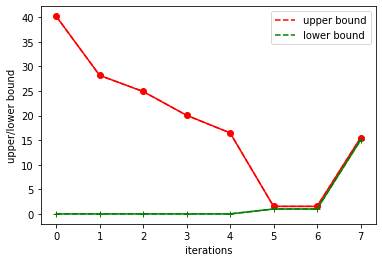

In [297]:
import matplotlib.pyplot as plt

print(optimal_history)

ubs = []
lbs = []
x = []

for i in range(len(optimal_history)):
  x.append(i)
  ubs.append(optimal_history[i][0])
  lbs.append(optimal_history[i][1])

l1=plt.plot(x,ubs,'r--',label='upper bound')
l2=plt.plot(x,lbs,'g--',label='lower bound')
plt.plot(x,ubs,'ro-',x,lbs,'g+-')
plt.xlabel('iterations')
plt.ylabel('upper/lower bound')
plt.legend()
plt.show()




In [298]:
x_left = p_left[:, 0]
y_left = p_left[:, 1]

x_right = p_right[:, 0]
y_right = p_right[:, 1]

img1 =  cv2.imread('InputLeftImage.png')
img2 = cv2.imread('InputRightImage.png')

h1 = img1.shape[0]
w1 = img1.shape[1]

h2 = img2.shape[0]
w2= img2.shape[1]

view = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
view[:h1, :w1, :] = img1  
view[:h2, w1:, :] = img2
view[:, :, 1] = view[:, :, 0]  
view[:, :, 2] = view[:, :, 0]

for i in range(x_left.shape[0]):
    # draw the keypoints
    # print m.queryIdx, m.trainIdx, m.distance
    cv2.line(view, (int(x_left[i]), int(y_left[i])) , (int(x_right[i] + w1), int(y_right[i])), (255, 0, 0), 1)

cv2.imwrite('original_correspondence.png', view)

view1 = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
view1[:h1, :w1, :] = img1  
view1[:h2, w1:, :] = img2
view1[:, :, 1] = view[:, :, 0]  
view1[:, :, 2] = view[:, :, 0]

x_inliers_left = inliers_left[:, 0]
y_inliers_left = inliers_left[:, 1]
x_inliers_right = inliers_right[:, 0]
y_inliers_right = inliers_right[:, 1]

for i in range(x_inliers_left.shape[0]):
    # draw the keypoints
    # print m.queryIdx, m.trainIdx, m.distance
    cv2.line(view1, (int(x_inliers_left[i]), int(y_inliers_left[i])) , (int(x_inliers_right[i] + w1), int(y_inliers_right[i])), (0, 255, 0), 1)

x_outliers_left = outliers_left[:, 0]
y_outliers_left = outliers_left[:, 1]
x_outliers_right = outliers_right[:, 0]
y_outliers_right = outliers_right[:, 1]

for i in range(x_outliers_left.shape[0]):
  cv2.line(view1, (int(x_outliers_left[i]), int(y_outliers_left[i])) , (int(x_outliers_right[i] + w1), int(y_outliers_right[i])), (0, 0, 255), 1)


cv2.imwrite('corrected_correspondence.png', view1)








True

In [299]:
 
  # thres = 3

  # data = scipy.io.loadmat('ListInputPoints.mat')
  # input_points = np.array(data['ListInputPoints'])
  # p_left = input_points[:, 0:2]
  # p_right = input_points[:, 2:4]
  
  # n = p_left.shape[0]

  # x_xd_delta = p_left[:, 0 ] - p_right[:, 0] - thres
  # y_yd_delta = p_left[:, 1 ] - p_right[:, 1] - thres

  # xd_x_delta = -p_left[:, 0 ] + p_right[:, 0] - thres
  # yd_y_delta = -p_left[:, 1 ] + p_right[:, 1] - thres

  # a = np.concatenate((np.zeros((n,2)), np.diag(x_xd_delta), np.eye(n), np.zeros((n,n))), axis = 1)
  # c = np.concatenate((np.zeros((n,2)), np.diag(xd_x_delta), -np.eye(n), np.zeros((n,n))), axis = 1)
  # d = np.concatenate((np.zeros((n,2)), np.diag(y_yd_delta), np.zeros((n,n)), np.eye(n)), axis = 1)
  # e = np.concatenate((np.zeros((n,2)), np.diag(yd_y_delta), np.zeros((n,n)), -np.eye(n)), axis = 1)

  # A1 = np.concatenate((a, c, d, e), axis = 0)
  
  # b1 = np.zeros((4*n, 1))

  # Tx_lb = -1104
  # Ty_lb = -549
  # Tx_ub = 0
  # Ty_ub = 549

  # print(Tx_lb, Ty_lb, Tx_ub, Ty_ub)
  

  # f = np.concatenate((np.zeros((n,2)), Tx_lb * np.eye(n), -np.eye(n), np.zeros((n, n))), axis = 1)
  # g = np.concatenate((np.ones((n,1)), np.zeros((n,1)), Tx_ub * np.eye(n), -np.eye(n), np.zeros((n, n))), axis = 1)
  # h = np.concatenate((-np.ones((n,1)), np.zeros((n,1)), -Tx_lb * np.eye(n), np.eye(n), np.zeros((n, n))), axis = 1)
  # i = np.concatenate((np.zeros((n,2)), -Tx_ub * np.eye(n), np.eye(n), np.zeros((n, n))), axis = 1)

  # A2 = np.concatenate((f, g, h, i), axis = 0)

  # b2 = np.concatenate((np.zeros((n, 1)), Tx_ub * np.ones((n, 1)), -Tx_lb * np.ones((n, 1)), np.zeros((n, 1))), axis = 0)



  # j = np.concatenate((np.zeros((n,2)), Ty_lb * np.eye(n), np.zeros((n, n)), -np.eye(n)), axis = 1)
  # k = np.concatenate((np.zeros((n,1)), np.ones((n,1)), Ty_ub * np.eye(n), np.zeros((n, n)), -np.eye(n)), axis = 1)
  # l = np.concatenate((np.zeros((n,1)), -np.ones((n,1)), -Ty_lb * np.eye(n), np.zeros((n, n)), np.eye(n)), axis = 1)
  # m = np.concatenate((np.zeros((n,2)), -Ty_ub * np.eye(n), np.zeros((n, n)), np.eye(n)), axis = 1)
  
  # A3 = np.concatenate((j, k, l, m), axis = 0)
  # b3 = np.concatenate((np.zeros((n, 1)), Ty_ub * np.ones((n, 1)), -Ty_lb * np.ones((n, 1)), np.zeros((n, 1))), axis = 0)  

  # A = np.concatenate((A1, A2, A3), axis = 0)
  # b = np.concatenate((b1, b2, b3), axis = 0)
  # # np.set_printoptions(threshold=np.inf)
  # # print(A)
  # # print(b)

  # c = np.concatenate((np.zeros((1, 1)), np.zeros((1, 1)), -np.ones((n, 1)), np.zeros((2 * n, 1))), axis = 0)

  # print(A.shape)

  # print(b.shape)

  # bounds = []
  # bounds.append((Tx_lb, Tx_ub))
  # bounds.append((Ty_lb, Ty_ub))
  # for i in range(n):
  #   bounds.append((0, 1))
  
  # for i in range(2*n):
  #   bounds.append((None, None))

  # res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, options={'lstsq': False, 'sym_pos': True, 'tol': 1e-6})

  # print(res)